# Data Analysis of Coursera Course Data: Focus on Python Visualization

This notebook, titled "coursera_course_project", presents an analysis of Coursera courses. It includes analysis questions, code, and insights derived from the dataset. The dataset used is sourced from Kaggle: https://www.kaggle.com/datasets/siddharthm1698/coursera-course-dataset.

The dataset contains 890 observations, where each row represents a course, and 6 features, where each column represents a course attribute. Detailed description:

1. course_title : Contains the course title.
2. course_organization : It tells which organization is conducting the courses.
3. course_Certificate_type : It has details about what are the different certifications available in courses.
4. course_rating : It has the ratings associated with each course.
5. course_difficulty : It tells about how difficult or what is the level of the course.
6. course_students_enrolled : It has the number of students that are enrolled in the course.

It is important to note that this dataset does not contain any date information, making it unclear when specific courses started or how long they have been available. This is a limitation for the analysis, as insights will be constrained by the absence of time-based data.

**The main analysis question are:**
Which Coursera courses and attributes are the most popular, and which courses are worth investing in to attract more students?

# Data Loading and Cleaning

Importing required libraries and loading the dataset:

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import cufflinks as cf
import kagglehub

%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
cf.go_offline();

In [41]:
coursera_filepath = kagglehub.dataset_download("siddharthm1698/coursera-course-dataset")

print("Path to dataset directory:", coursera_filepath)

files_in_directory = os.listdir(coursera_filepath)
print("Files in dataset directory:", files_in_directory)

csv_file_path = os.path.join(coursera_filepath, files_in_directory[0])

coursera_data = pd.read_csv(csv_file_path, index_col=0)
coursera_data.head()

Path to dataset directory: /home/ubuntu/.cache/kagglehub/datasets/siddharthm1698/coursera-course-dataset/versions/1
Files in dataset directory: ['coursea_data.csv']


,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
134,(ISC)² Systems Security Certified Practitioner (SSCP),(ISC)²,SPECIALIZATION,4.7,Beginner,5.3k
743,A Crash Course in Causality: Inferring Causal Effects from Observational Data,University of Pennsylvania,COURSE,4.7,Intermediate,17k
874,A Crash Course in Data Science,Johns Hopkins University,COURSE,4.5,Mixed,130k
413,A Law Student's Toolkit,Yale University,COURSE,4.7,Mixed,91k
635,A Life of Happiness and Fulfillment,Indian School of Business,COURSE,4.8,Mixed,320k


Checking the number of rows and columns:

In [42]:
coursera_data.shape

(891, 6)

Data cleaning: this dataset contains **no NULL values** and **all rows are unique**.

In [43]:
coursera_data.isna().any()

course_title                False
course_organization         False
course_Certificate_type     False
course_rating               False
course_difficulty           False
course_students_enrolled    False
dtype: bool

In [44]:
uniques = coursera_data.drop_duplicates()

uniques.shape

(891, 6)

Below is a list of the **data types** for all columns:

In [45]:
coursera_data.dtypes

course_title                 object
course_organization          object
course_Certificate_type      object
course_rating               float64
course_difficulty            object
course_students_enrolled     object
dtype: object

**Converting the "course_students_enrolled" column data type to integer** to enable calculations with this column. Treating thousands (k) and millions (m) appropriately:

In [46]:
def convert_to_int(value: str | int) -> int:
    """
    Convert a string representing a number with suffix 'k' for thousands or 'm' for millions
    to an integer. If the value is already an integer, it is returned as is.

    Parameters:
    - value (str | int): A number in string format, optionally followed by 'k' (thousand) or 'm' (million), or an integer.

    Returns:
    - int: The integer representation of the input value.

    Examples:
    - "5k" becomes 5000
    - "3.5m" becomes 3500000
    - "200" becomes 200
    """
    if isinstance(value, int):
        return value
    value = value.lower()
    if "k" in value:
        return int(float(value.replace("k", "")) * 1000)
    elif "m" in value:
        return int(float(value.replace("m", "")) * 1000000)
    return int(value)


coursera_data["course_students_enrolled"] = coursera_data[
    "course_students_enrolled"
].apply(convert_to_int)

**Convert the "course_Certificate_type" and the "course_difficulty" column data type to categorical** to enable faster processing and improve code performance:

In [47]:
coursera_data["course_Certificate_type"] = coursera_data[
    "course_Certificate_type"
].astype("category")

coursera_data["course_difficulty"] = coursera_data["course_difficulty"].astype(
    "category"
)

coursera_data.dtypes

course_title                  object
course_organization           object
course_Certificate_type     category
course_rating                float64
course_difficulty           category
course_students_enrolled       int64
dtype: object

Checking for **outliers** in numeric columns using boxplot. First, analyzing outliers in the "course_students_enrolled" column (in millions), we can see a bunch of outliers, both mild and extreme. The average number of students enrolled in a course is 42k, with an upper fence of 220k. There are outliers above this upper fence, suggesting that some courses are more popular than others. I decided to retain these outliers, as the number of students enrolled in each course can vary based on individual choices. In the later analysis, we will examine which courses are the most popular.

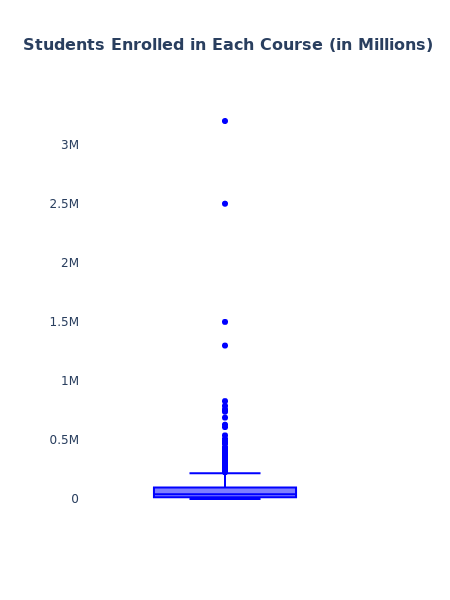

In [48]:
from IPython.display import Image

fig_enrolled = px.box(
    coursera_data,
    y="course_students_enrolled",
    title="Students Enrolled in Each Course (in Millions)",
    color_discrete_sequence=["blue"]
)
fig_enrolled.update_layout(
    title=dict(font=dict(size=16, family="Arial", weight="bold")),
    width=450,
    height=600,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, title=""),
)

fig_enrolled.write_image("fig_enrolled.png")

Image(filename="fig_enrolled.png")

Analyzing **outliers** in the "course_rating" column, which reflect the ratings associated with each course, we observe six outliers that fall below the common rating. The average course rating score for all courses is 4.7, with the lower fence set at 4.3. I decided to retain these outliers since all course rating scores lie within the available rating range, and student satisfaction and experience can vary. Later in the analysis, we will identify which courses have the highest and lowest rating scores.

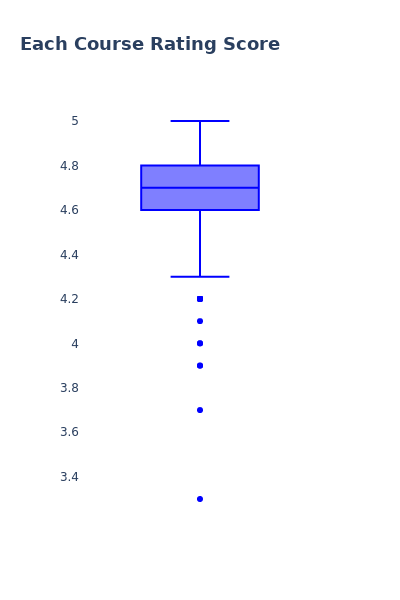

In [49]:
from IPython.display import Image

fig_rating = px.box(
    coursera_data,
    y="course_rating",
    title="Each Course Rating Score",
    color_discrete_sequence=["blue"])
fig_rating.update_layout(
    title=dict(font=dict(size=18, family="Arial", weight="bold")),
    width=400,
    height=600,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, title=""),
)

fig_rating.write_image("fig_rating.png")

Image(filename="fig_rating.png")

Second inspection for outliers in the "course_students_enrolled" and "course_rating" column via the IQR method to see how many outliers are there:

In [50]:
numeric_columns = ["course_students_enrolled",
                   "course_rating"
                   ]

outliers_dict = {}

for column in numeric_columns:
    Q1 = coursera_data[column].quantile(0.25)
    Q3 = coursera_data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = coursera_data[
    (coursera_data[column] < lower_bound) | (coursera_data[column] > upper_bound)
]

    outliers_dict[column] = outliers

for column, outliers in outliers_dict.items():
    print(f"Column: {column}. Number of outliers: {len(outliers)}")

Column: course_students_enrolled. Number of outliers: 78
Column: course_rating. Number of outliers: 17


# Exploratory Data Analysis

In total, there are **888 unique courses** in this Coursera dataset:

In [51]:
courses_count = coursera_data["course_title"].value_counts()

unique_courses_count = len(courses_count)

unique_courses_count

888

**Courses, that are taught more than one time** include "Developing Your Musicianship", "Marketing Digital", and "Machine Learning".

In [52]:
courses_count = coursera_data["course_title"].value_counts()

multiple_courses = courses_count[courses_count > 1].index

multiple_courses_df = coursera_data[
    coursera_data["course_title"].isin(multiple_courses)
]

courses_with_organization = multiple_courses_df.groupby("course_title")[
    "course_organization"
].unique()

courses_with_organization

course_title
Developing Your Musicianship                          [Berklee College of Music]
Machine Learning                 [University of Washington, Stanford University]
Marketing Digital               [Universidade de São Paulo, Universidad Austral]
Name: course_organization, dtype: object

Investigating **why these courses appear twice at the same or different institutions**: The "Developing Your Musicianship" course is offered twice at the Berklee College of Music, but the certification type and course difficulty differ. Additionally, "Machine Learning" and "Marketing Digital" are taught at different universities, each with varying certification types. The "Machine Learning" course also has a different difficulty level. **Notably, both "Machine Learning" courses attract significantly more students than the upper fence set at 220k.** The course with mixed difficulty attracts 3.2M students, while the specialization certification with intermediate difficulty attracts 290k students.

In [53]:
course_titles = [
    "Developing Your Musicianship",
    "Machine Learning",
    "Marketing Digital",
]

selected_courses = coursera_data[coursera_data["course_title"].isin(course_titles)]

selected_courses

,course_title,course_organization,course_Certificate_type,course_rating,course_difficulty,course_students_enrolled
756,Developing Your Musicianship,Berklee College of Music,COURSE,4.8,Mixed,41000
205,Developing Your Musicianship,Berklee College of Music,SPECIALIZATION,4.8,Beginner,54000
181,Machine Learning,University of Washington,SPECIALIZATION,4.6,Intermediate,290000
6,Machine Learning,Stanford University,COURSE,4.9,Mixed,3200000
241,Marketing Digital,Universidade de São Paulo,COURSE,4.8,Beginner,81000
325,Marketing Digital,Universidad Austral,SPECIALIZATION,4.7,Beginner,39000


In total, there are **154 course organizations**:

In [54]:
organization_count = coursera_data["course_organization"].value_counts()

unique_organization_count = len(organization_count)

unique_organization_count

154

Below are the **top 5 course organizations** based on the number of courses they offer. Four of these are universities, while one is Google Cloud. The University of Pennsylvania offers the most courses, with a total of 59:

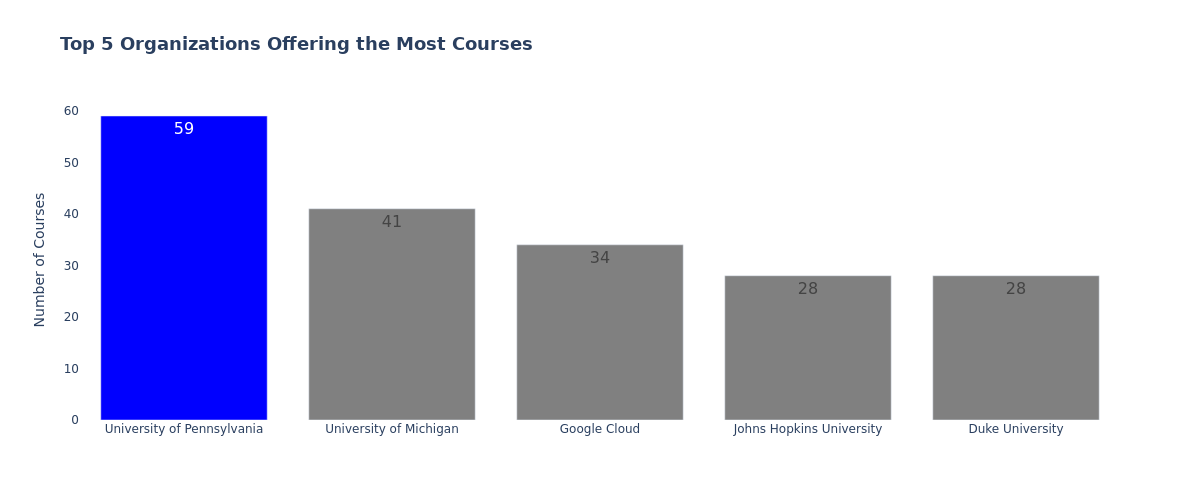

In [55]:
from IPython.display import Image

organization_counts = coursera_data["course_organization"].value_counts().head()
top_organizations = organization_counts.reset_index()
top_organizations.columns = ["course_organization", "course_count"]

fig = px.bar(
    top_organizations,
    x="course_organization",
    y="course_count",
    title="Top 5 Organizations Offering the Most Courses",
    text="course_count"
)

fig.update_traces(
    marker_color=["blue"] + ["grey"] * (len(top_organizations) - 1), textfont_size=16
)

fig.update_layout(
    width=1200,
    showlegend=False,
    title=dict(font=dict(size=18, family="Arial", weight="bold")),
    yaxis=dict(title="Number of Courses", showgrid=False),
    xaxis=dict(showgrid=False, title=""),
    plot_bgcolor="white"
)

fig.write_image("fig_organization_counts.png")

Image(filename="fig_organization_counts.png")

Below is a bar chart showing **the average rating of courses from the top 5 organizations, all rated 4.9, along with the organization with the lowest rating, which is 4.275**. The gap between these ratings is only 0.625. We can observe that none of the organizations has a low average course rating. It's important to note that **ratings are subjective**; each student rates a course by selecting from the five stars, and course reviews are optional:

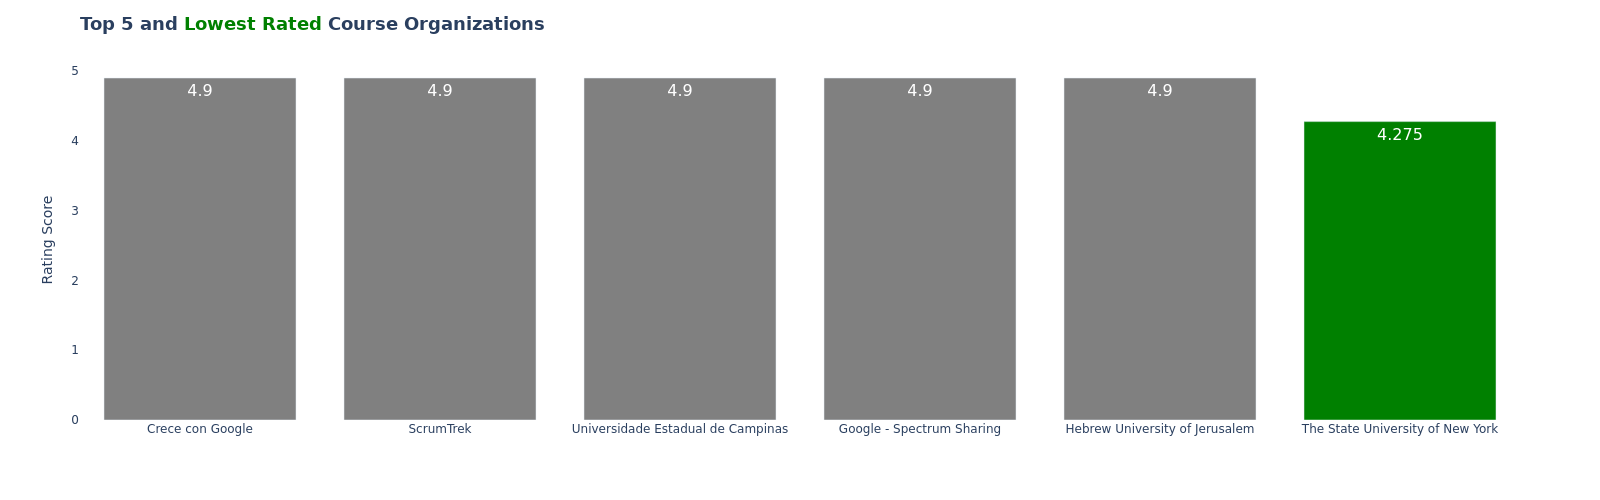

In [56]:
from IPython.display import Image

average_ratings = (
    coursera_data.groupby("course_organization")["course_rating"]
    .mean()
    .sort_values(ascending=False)
)

top_5_organizations = average_ratings.head()
lowest_rating = average_ratings.tail(1)
combined_ratings = pd.concat([top_5_organizations, lowest_rating])

fig = px.bar(
    combined_ratings.reset_index(),
    x="course_organization",
    y=combined_ratings.name,
    text=combined_ratings.name
)

colors = ["grey"] * 5 + ["green"]
fig.update_traces(marker_color=colors, textfont_color=["white"] * 6, textfont_size=16)

fig.update_layout(
    width=1600,
    showlegend=False,
    title=dict(
        text="Top 5 and <span style='color:green'>Lowest Rated</span> Course Organizations",
        font=dict(size=18, family="Arial", weight="bold")
    ),
    yaxis=dict(title="Rating Score", showgrid=False),
    xaxis=dict(showgrid=False, title=""),
    plot_bgcolor="white"
)

fig.write_image("fig_top_low_organization.png")

Image(filename="fig_top_low_organization.png")

Let's take another look at the **distribution of course ratings among all courses**. **The median rating score is 4.7**, with the highest possible score being 5. The lower fence is set at 4.3. However, there are six outliers below this lower fence. The lowest score recorded is 3.3:

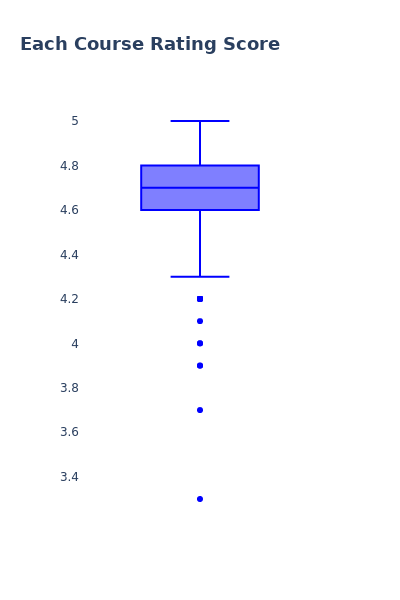

In [57]:
from IPython.display import Image

fig_rating = px.box(
    coursera_data,
    y="course_rating",
    title="Each Course Rating Score",
    color_discrete_sequence=["blue"])
fig_rating.update_layout(
    title=dict(font=dict(size=18, family="Arial", weight="bold")),
    width=400,
    height=600,
    plot_bgcolor="white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False, title=""),
)

fig_rating.write_image("fig_rating.png")

Image(filename="fig_rating.png")

Below is a list of the **top 10 best rated courses**. The courses rated with a score of 5 are "Infectious Disease Modelling" and "El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho", which translates to "The Lawyer of the Future: Legaltech and the Digital Transformation of the Law". However, both courses have relatively few students enrolled, with 1600 and 1500, respectively. Additionally, **most attributes of these top 10 rated courses differ**. Therefore, we cannot draw a conclusion about why some courses or topics are more popular and worth investing in.

In [58]:
top_10_rated_courses = coursera_data.nlargest(10, "course_rating")

print(top_10_rated_courses.to_string(index=False))

                                                                                                              course_title                course_organization  course_Certificate_type  course_rating course_difficulty  course_students_enrolled
                                                  El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho                Universidad Austral                   COURSE            5.0          Beginner                      1500
                                                                                              Infectious Disease Modelling            Imperial College London           SPECIALIZATION            5.0      Intermediate                      1600
                                                                         Agile и Scrum в работе над проектами и продуктами                          ScrumTrek                   COURSE            4.9          Beginner                     12000
                                

Let's analyze **which courses have the highest ratings within each difficulty level**. At the beginner level, there is a course rated 5, titled "El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho", which translates to "The Lawyer of the Future: Legaltech and the Digital Transformation of the Law". The intermediate level features a course rated 5, "Infectious Disease Modelling". At the advanced level, the course "Medical Neuroscience" has a rating of 4.9, while the mixed level course "Become a CBRS Certified Professional Installer by Google" also has a rating of 4.9. **Two of these topics are related to medicine at the intermediate and advanced levels, while the other two are focused on the IT sector at the beginner and mixed levels**.

In [59]:
highest_rated_courses = coursera_data.loc[
    coursera_data.groupby("course_difficulty", observed=False)["course_rating"].idxmax()
]

highest_rated_courses_table = highest_rated_courses[
    ["course_difficulty", "course_title", "course_rating"]
]

highest_rated_courses_table = highest_rated_courses_table.sort_values(
    by="course_rating", ascending=False
)

pd.set_option("display.max_colwidth", None)

highest_rated_courses_table

,course_difficulty,course_title,course_rating
789,Beginner,El Abogado del Futuro: Legaltech y la Transformación Digital del Derecho,5.0
401,Intermediate,Infectious Disease Modelling,5.0
214,Advanced,Medical Neuroscience,4.9
106,Mixed,Become a CBRS Certified Professional Installer by Google,4.9


Analyzing the distribution of courses across different difficulty levels among the 888 courses, we can see that **the majority are designed for beginners, with a total of 487 courses**. The intermediate and mixed levels have a similar number of courses, with 198 and 187, respectively. In contrast, the advanced level offers only 19 courses.

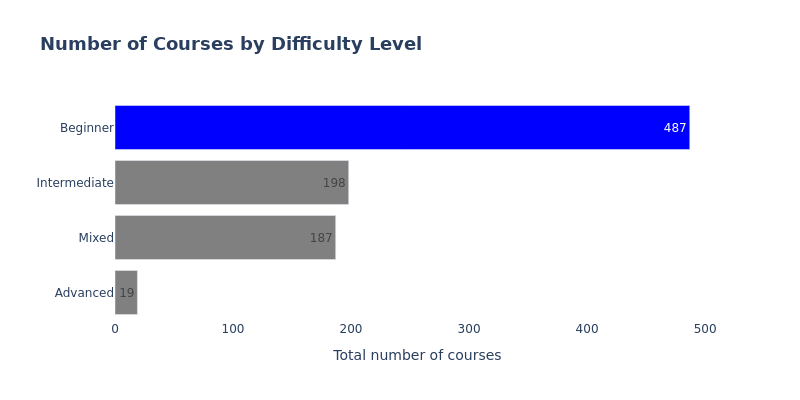

In [60]:
from IPython.display import Image

course_counts = coursera_data["course_difficulty"].value_counts().reset_index()
course_counts.columns = ["course_difficulty", "course_count"]

course_counts = course_counts.sort_values(by="course_count", ascending=True)

colors = ["grey"] * (len(course_counts) - 1) + ["blue"]

course_counts["color"] = colors

fig_counts = px.bar(
    course_counts,
    y="course_difficulty",
    x="course_count",
    orientation="h",
    title="Number of Courses by Difficulty Level",
    text="course_count",
    color="color",
    color_discrete_map={"blue": "blue", "grey": "grey"}
)

fig_counts.update_layout(
    width=800,
    height=400,
    plot_bgcolor="white",
    showlegend=False,
    xaxis=dict(showgrid=False, title="Total number of courses"),
    yaxis=dict(showgrid=False, title=""),
    title_font=dict(size=18, family="Arial", weight="bold")
)

fig_counts.write_image("count_courses_by_difficulty.png")

Image(filename="count_courses_by_difficulty.png")

However, when analyzing the average number of students enrolled per course by difficulty across the dataset, we find that the beginner level ranks second. **The mixed level is the most popular, with an average of over 133k students enrolled per course**. The advanced level is the least popular by this measure as well, with an average of over 66k students enrolled per course. This suggests that although most courses are designed for beginners, the highest average number of students enrolled per course is for the mixed level.

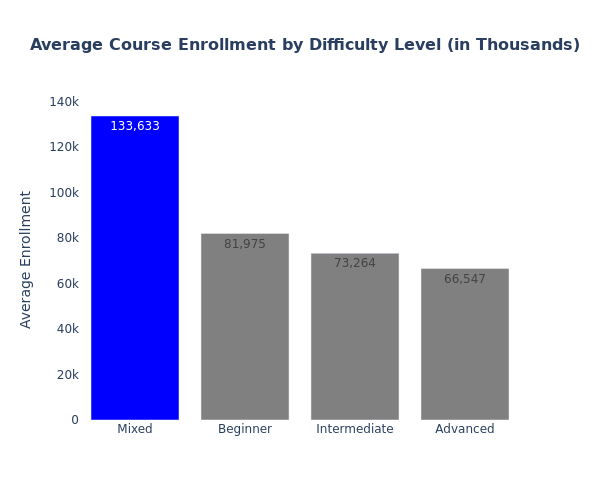

In [61]:
from IPython.display import Image

average_enrollment = (
    coursera_data.groupby("course_difficulty", observed=False)[
        "course_students_enrolled"
    ]
    .mean()
    .reset_index()
)

average_enrollment["average_enrollment"] = (
    average_enrollment["course_students_enrolled"].round(0).astype(int)
)

average_enrollment = average_enrollment.sort_values(
    by="average_enrollment", ascending=False
)

average_enrollment = average_enrollment[["course_difficulty", "average_enrollment"]]

colors = ["blue"] + ["grey"] * (len(average_enrollment) - 1)

average_enrollment["color"] = colors

fig_enrollment = px.bar(
    average_enrollment,
    x="course_difficulty",
    y="average_enrollment",
    title="Average Course Enrollment by Difficulty Level (in Thousands)",
    text="average_enrollment",
    color="color",
    color_discrete_map={"blue": "blue", "grey": "grey"}
)

fig_enrollment.update_traces(texttemplate="%{text:,}")

fig_enrollment.update_layout(
    width=600,
    height=500,
    plot_bgcolor="white",
    showlegend=False,
    xaxis=dict(showgrid=False, title=""),
    yaxis=dict(showgrid=False, title="Average Enrollment"),
    title_font=dict(size=16, family="Arial", weight="bold")
)

fig_enrollment.write_image("avg_enrollment_by_difficulty.png")

Image(filename="avg_enrollment_by_difficulty.png")


Below is a list of the top 10 courses with the highest student enrollment, all of which are considered outliers. **The most popular course, "Machine Learning," has 3.2 million students enrolled. In second place is "The Science of Well-Being," with 2.5 million students, followed by "Python for Everybody" with 1.5 million students.**

**Six out of these top 10 courses, highlighted in blue, are related to the IT sector, covering topics in AI and programming.** The remaining courses, shown in grey, cover various topics such as well-being, English language skills, and career development.

It is important to note that there is a limitation to this analysis: it is unclear when each course started or how long they have been available, thus it can have an effect on this comparison. Therefore, based on this Coursera data, we can only conclude that a significant portion of popular topics are related to the IT sector.

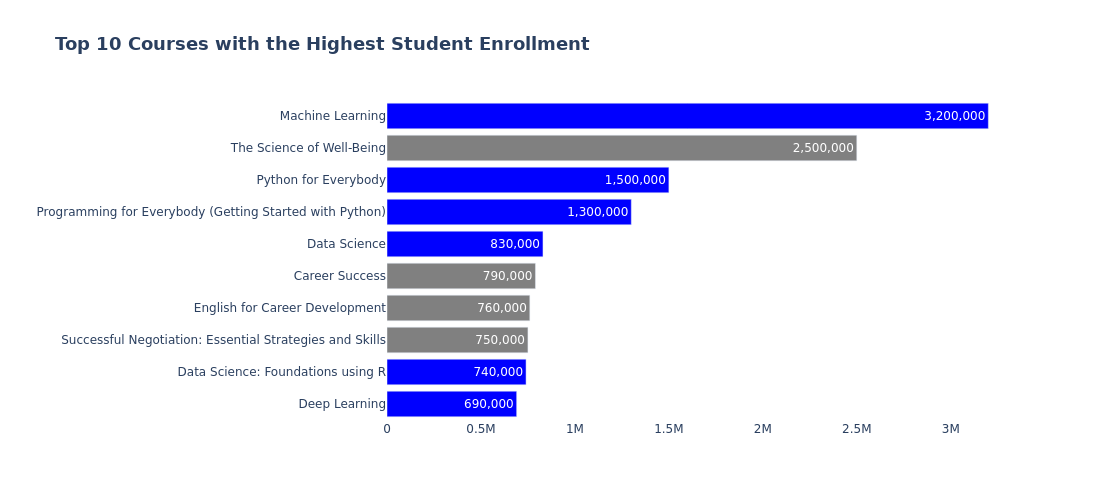

In [62]:
from IPython.display import Image

top_10_courses = coursera_data.sort_values(
    by="course_students_enrolled", ascending=False
).head(10)

colors = [
    "blue" if i in [0, 2, 3, 4, 8, 9] else "grey" for i in range(len(top_10_courses))
]

top_10_courses["color"] = colors

fig_top_courses = px.bar(
    top_10_courses,
    x="course_students_enrolled",
    y="course_title",
    title="Top 10 Courses with the Highest Student Enrollment",
    text="course_students_enrolled",
    orientation="h",
    color="color",
    color_discrete_map={"blue": "blue", "grey": "grey"}
)

fig_top_courses.update_traces(
    texttemplate="%{text:,}", textposition="inside", textfont_color="white"
)

fig_top_courses.update_layout(
    width=1100,
    height=500,
    plot_bgcolor="white",
    showlegend=False,
    xaxis=dict(showgrid=False, title=""),
    yaxis=dict(showgrid=False, title="", categoryorder="total ascending"),
    title_font=dict(size=18, family="Arial", weight="bold")
)

fig_top_courses.write_image("top_courses.png")

Image(filename="top_courses.png")

**Analyzing the relationship between course ratings and student enrollment reveals a very weak correlation of just 0.07.** The correlation chart indicates that most courses tend to have relatively high ratings. Interestingly, the highest-rated courses can have varying enrollment figures, ranging from as few as 1,500 students to as many as 3.2 million.

Consequently, we cannot establish a meaningful correlation between course ratings and student enrollment; these two factors appear to operate independently of each other.

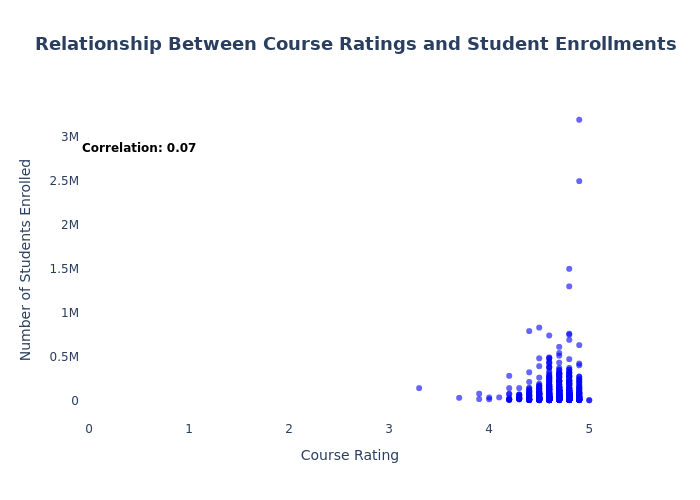

In [63]:
from IPython.display import Image

correlation = coursera_data["course_rating"].corr(
    coursera_data["course_students_enrolled"]
)

fig = px.scatter(
    coursera_data,
    x="course_rating",
    y="course_students_enrolled",
    color_discrete_sequence=["blue"],
    title="Relationship Between Course Ratings and Student Enrollments",
    labels={
        "course_rating": "Course Rating",
        "course_students_enrolled": "Number of Students Enrolled",
    },
    opacity=0.6
)

fig.add_annotation(
    x=0.5,
    y=max(coursera_data["course_students_enrolled"]) * 0.9,
    text=f"<b>Correlation: {correlation:.2f}</b>",
    showarrow=False,
    font=dict(size=12, color="black")
)

fig.update_layout(
    plot_bgcolor="white",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    title_font=dict(size=18, family="Arial", weight="bold"),
    width=700,
    height=500
)

fig.write_image("corr_ratings_enrollment.png")

Image(filename="corr_ratings_enrollment.png")

The percentage of the 888 courses by certification type is as follows: 65.3% of the total courses have a course status, while 33.3% offer a specialization certification type. A very small portion, just 1.35%, offers a professional certificate. In summary, **the majority of courses provide a course status, with specialization certifications following, while professional certificates are quite rare.**

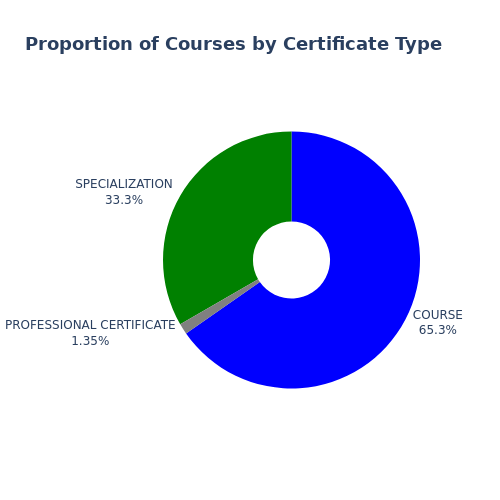

In [64]:
from IPython.display import Image

certified_courses = coursera_data[coursera_data["course_Certificate_type"].notna()]

certificate_counts = (
    certified_courses["course_Certificate_type"].value_counts(normalize=True) * 100
)

certificate_counts_df = certificate_counts.reset_index()
certificate_counts_df.columns = ["course_Certificate_type", "percentage"]

certificate_counts_df = certificate_counts_df.sort_values(
    by="percentage", ascending=True
)

fig_certificates = px.pie(
    certificate_counts_df,
    names="course_Certificate_type",
    values="percentage",
    title="Proportion of Courses by Certificate Type",
    hole=0.3,
    color_discrete_sequence=["blue", "green", "grey"]
)

fig_certificates.update_traces(textinfo="percent+label", textposition="outside")

fig_certificates.update_traces(hovertemplate="%{label}: %{percent:.2%}")

fig_certificates.update_layout(
    width=500,
    height=500,
    plot_bgcolor="white",
    showlegend=False,
    title_font=dict(size=18, family="Arial", weight="bold")
)

fig_certificates.write_image("certificates_proportion.png")

Image(filename="certificates_proportion.png")

While professional certificate courses have the lowest percentage among all course certification types, they rank first in terms of average student enrollment, with more than 190k students enrolled on average. In comparison, specializations have around 92k average enrollments, and regular courses have approximately 88k.

This suggests that **professional certificate courses are not an unpopular choice among students when considering enrollment numbers. Since specializations and regular courses offer a wider variety of options, their average enrollments are lower due to this greater variability in student distribution across courses.**

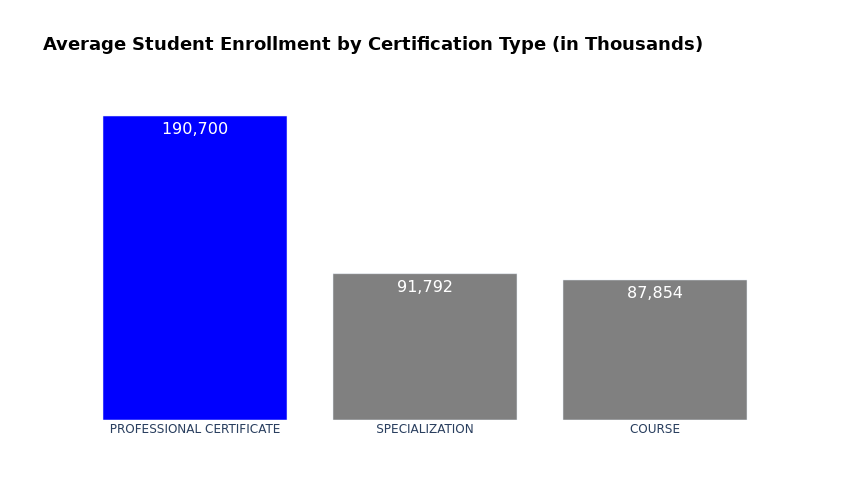

In [65]:
from IPython.display import Image

avg_enrollment = (
    coursera_data.groupby("course_Certificate_type", observed=True)[
        "course_students_enrolled"
    ]
    .mean()
    .reset_index()
)

avg_enrollment = avg_enrollment.sort_values(
    by="course_students_enrolled", ascending=False
)

colors = ["blue"] + ["grey"] * (len(avg_enrollment) - 1)

fig = px.bar(
    avg_enrollment,
    x="course_Certificate_type",
    y="course_students_enrolled",
    title="Average Student Enrollment by Certification Type (in Thousands)"
)

fig.update_traces(
    texttemplate="%{y:,.0f}",
    marker_color=colors,
    showlegend=False,
    textfont=dict(color="white", size=16)
)

fig.update_layout(
    width=850,
    height=500,
    plot_bgcolor="white",
    title_font=dict(size=18, family="Arial", color="black", weight="bold"),
    xaxis=dict(showgrid=False, title=""),
    yaxis=dict(showgrid=False, visible=False)
)

fig.write_image("avg_enrollment_by_certification.png")

Image(filename="avg_enrollment_by_certification.png")

**Summary:** 

**Main Analysis Questions:** Which Coursera courses and attributes are the most popular, and which courses are worth investing in to attract more students?

The analysis of Coursera course data reveals that certain courses, identified as outliers, are highly popular in terms of student enrollment. **The top course, "Machine Learning," has 3.2M  students, followed by "The Science of Well-Being" with 2.5M, and "Python for Everybody" with 1.5M.** Notably, there are two versions of "Machine Learning" offered with different difficulty levels, certification types, and universities, each drawing significantly more students than the upper threshold of 220k enrollments.

**Six of the top 10 courses relate to IT topics such as AI and programming**, with the remainder covering well-being, language skills, and career development. However, due to the lack of data on course launch dates, these popularity comparisons may be influenced by course duration on the platform. Based on the available data, a substantial portion of popular topics are in the IT sector.

**Course ratings analysis** shows a median rating of 4.7. Among the highest-rated courses (scoring 5), "Infectious Disease Modelling" and "The Lawyer of the Future" each have fewer enrollments (1,500–1,600 students). With varied attributes among top-rated courses, no clear trend explains why some courses are more popular or investment-worthy based on ratings alone.

**The relationship between course ratings and student enrollment shows a very weak correlation of 0.07.** While most courses have high ratings, their enrollment varies widely, from 1.5k to over 3M students.

**Course Attributes Analysis: Among the 888 courses analyzed, the majority (487) are beginner-level**, with intermediate and mixed levels at 198 and 187, respectively, and advanced courses at just 19. **Despite this, the mixed-level courses have the highest average enrollments (133k students)**, suggesting that although most courses are beginner-focused, the mixed level attracts more students per course on average.

**Certification Types Analysis** shows that most courses are general, followed by specializations, with professional certificates making up only 1.35% of courses. However, **professional certificate courses are not unpopular; they attract high enrollments on average**. Since specializations and regular courses offer a broader range of options, their average enrollments are somewhat lower due to greater variation across student distribution.

# FURTHER ANALYSIS

Here are some suggestions how this analysis can be improved and further implemented:
- For a deeper analysis and stronger conclusions, it is important to examine the start dates of specific courses. This would help determine whether the high enrollment numbers in popular courses are due to their longevity or other factors.
- Additionally, a year-by-year comparison of all courses or specific ones within set time boundaries could provide further insights.









